# Qracon- E91 with Qiskit

這是一篇關於如何使用Qiskit建立一個E91演算法並得出金鑰的筆記
接下來我將會介紹E91協議的執行原理和如何執行，希望本程式能夠在讀者理解此演算法的過程中起到些幫助，或是讓讀者在復刻此程式時能帶給讀者更多的樂趣。

## 量子糾纏
讓我們假設AB電子原為一體，現在當他們分裂成A和B電子時他們的旋轉方向會因角動量守恆而相反，當我們觀測A電子的自旋方向時，我們便能得知B電子的自旋方向。

這裡便是1種糾纏態，屬於其中一種Bell states 

$$\frac{1}{\sqrt{2}}(\lvert11\rangle + \lvert00\rangle)$$
而我們這次用到的 singlet state 可寫成以下，且也是屬於Bell state的一種。

$$\frac{1}{\sqrt{2}}(\lvert01\rangle - \lvert10\rangle)$$

## CHSH不等式
要說明CHSH不等式我們得先說明局域實在論，
1.資訊的傳輸不可超越光速 (局域論 Locality)
2.事物的存在不受觀測引響 (實在論 Realism) 

讓我們假設有一個人Victor將分別發送$\pm1$給Alice(A)與Bob(B)，而A與B將會從X和Y取一個方向量測V發送的訊號。
如此我們便能計算A與B的期望值總和。
$$A_XB_X\ +\ A_XB_Y +\ A_YB_X\ -\ A_YB_Y\ =\ (A_X\ +\ A_Y)B_X\ +\ \ (A_X\ -\ A_Y)B_Y$$
可以看出來$(A_X\ +\ A_Y)$或$(A_X\ -\ A_Y)$其一會是$0$，畢竟結果會是$-1,1$或$1,-1$其中的一個。
所以多次執行後上式的期望值應不大於$2$。$$-2\ \le\ C\ \le\ 2$$

但如果Victor不再發送古典的$\pm1$，而改發送糾纏量子對的話，經過實驗我們發現期望值居然大約等於$2.8$。
$$|CHSH\rangle\ \approx\ 2\sqrt{2}$$

我們可以假設今天Alice可以各自從X和Z方向擇一測量收到的糾纏對，Bob則可以從W或V方向選擇測量，其中 $W = \frac{1}{\sqrt{2}} (X + Z)$, $V = \frac{1}{\sqrt{2}} (-X + Z)$
那我們的測量期望值應為
\begin{eqnarray*}
 \langle X \otimes W \rangle_{\psi_s} &= -\frac{1}{\sqrt{2}}, \quad 
 \langle X \otimes V \rangle_{\psi_s} &= \frac{1}{\sqrt{2}}, \qquad\qquad  \\
 \langle Z \otimes W \rangle_{\psi_s} &= -\frac{1}{\sqrt{2}}, \quad
 \langle Z \otimes V \rangle_{\psi_s} &= -\frac{1}{\sqrt{2}}.
\end{eqnarray*}
$$C =
\langle X\otimes W \rangle - \langle X \otimes V \rangle + \langle Z \otimes W \rangle + \langle Z \otimes V \rangle =
-2 \sqrt{2}. \qquad\qquad $$

這違背了我們之前古典物理中所證明的期望值絕對值應不大於 $2$ 的理論，所以該理論假設的局域論與實在論勢必會有一個不存在於量子力學，這代表了這些量子在觀測前不存在一個確定的值。
當然我們可用此不等式來檢查量子是否糾纏，且這正是我們要做的。

更多內容可以參考[這裡](https://learning.quantum.ibm.com/tutorial/chsh-inequality)

## 金鑰製作
請先確認**qiskit version = 1.1.1**，其餘版本可能導致程式碼失效。

In [1]:
from qiskit import __version__
__version__

'1.1.1'

一樣先導入會用到的庫備用

In [2]:
import numpy as np
import random
import re
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer

製作一個電路使2個qubits成為上面提到的 singlet 糾纏態，並為其建立4個classicalbits。

In [3]:
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")
singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

#singlet.draw('mpl') #用以觀察電路

製作Alice與Bob各自的三個測量方向 $(X,Z,W,V)$。!\begin{align*}
 b_i = 1: \quad \vec{a}_1 &= (1,0,0) \quad (X \text{ observable}) &
 b_j^{'} = 1: \quad \vec{b}_1 &= \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (W \text{ observable})
 \\
 b_i = 2: \quad \vec{a}_2 &= \left(\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (W \text{ observable}) &
 b_j^{'} = 2: \quad \vec{b}_2 &= (0,0,1) \quad ( \text{Z observable})
 \\
 b_i = 3: \quad \vec{a}_3 &= (0,0,1) \quad (Z \text{ observable}) &
 b_j^{'} = 3: \quad \vec{b}_3 &= \left(-\frac{1}{\sqrt{2}},0,\frac{1}{\sqrt{2}}\right) \quad (V \text{ observable})
\end{align*}![vectors](https://hackmd.io/_uploads/HkDUVFWOA.png)


In [4]:
## Alice的觀測器電路

#A1電路用 X 基底測量qubits
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

#A2電路用 W 基底測量qubits
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.s(qr[0])
measureA2.h(qr[0])
measureA2.t(qr[0])
measureA2.h(qr[0])
measureA2.measure(qr[0],cr[0])

#A3電路用 Z 基底測量qubits
measureA3 = QuantumCircuit(qr, cr, name='measureA3')
measureA3.measure(qr[0],cr[0])

## Bob的觀測器電路

#B1電路用 W 基底測量qubits
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.s(qr[1])
measureB1.h(qr[1])
measureB1.t(qr[1])
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

#B2電路用 Z 基底測量qubits
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

#B3電路用 V 基底測量qubits
measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.tdg(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1],cr[1])

#將以上電路合併成List
aliceMeasurements = [measureA1, measureA2, measureA3]
bobMeasurements = [measureB1, measureB2, measureB3]

輸入發送的Singlet量子對數量
並隨機選擇Alice與Bob將使用的測量方向

In [5]:
numberOfSinglets = 500

aliceMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] 
bobMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] 

將測量電路根據上翻選擇的測量方向組合至電路中
首先產生一個singlet量子對，並將第一顆給Alice測量，第二顆給Bob測量。
最後再為每個電路命名。

In [16]:
circuits = []

for i in range(numberOfSinglets):
    #合併singlet電路兩個觀測電路
    circuitName = singlet.compose(aliceMeasurements[aliceMeasurementChoices[i]-1]).compose(bobMeasurements[bobMeasurementChoices[i]-1])
    
    #命名電路
    circuitName.name=f'{str(i)}:A{str(aliceMeasurementChoices[i])} B{str(bobMeasurementChoices[i] + 2)}'

    
    #將電路加至List中
    circuits.append(circuitName)

0:A3 B5


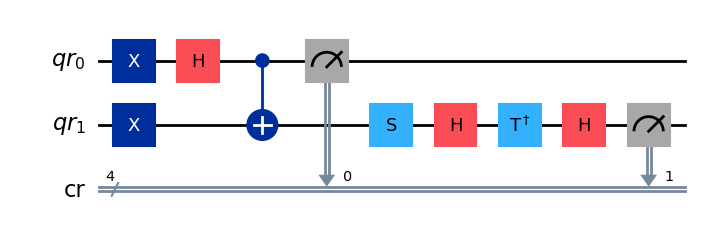

In [17]:
print(circuits[0].name) #可選擇其他circuits查看
circuits[0].draw('mpl')

接下來開始執行量子電路。
先選擇模擬器後執行電路，並印出結果。
這次選用可以批量執行電路的qasm_simulator。

In [18]:
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(circuits,shots=1).result()
print(result.get_counts(circuits[0]))

{'0001': 1}


應該會得到類似0010，Alice和Bob的結果儲存在前兩碼'10'上

接著我們利用python的正規表達式re來分類結果。

In [19]:
abPatterns = [
    re.compile('..00$'), #尋找後兩碼為00的結果(Alice和Bob各得到-1)
    re.compile('..01$'), #尋找後兩碼為01的結果
    re.compile('..10$'), #尋找後兩碼為10的結果(Alice得到-1、Bob得到1)
    re.compile('..11$')  # 尋找後兩碼為11的結果
]

然後將結果分類進aliceResults和bobResults中

In [20]:
aliceResults = [] # Alice的結果(string a)
bobResults = [] # Bob的結果(string a')

for i in range(numberOfSinglets):
    #將結果轉入res List中
    res = list(result.get_counts(circuits[i]).keys())[0]
    
    if abPatterns[0].search(res): #如果後兩碼為-1,-1
        aliceResults.append(-1) #紀錄Alice得到-1
        bobResults.append(-1) #紀錄Bob得到-1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): ##如果後兩碼為-1,1
        aliceResults.append(-1) #紀錄Alice得到-1
        bobResults.append(1) #紀錄Bob得到1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

接著將以上結果比對並製成能夠加密的金鑰。
理論上根據singlet量子對，如果使用相同的觀測電路測量，Alice的結果應與Bob異號。

In [21]:
aliceKey = [] # Alice的密碼串
bobKey = [] # Bob的密碼串

#比對Alice與Bob的觀測電路選擇
for i in range(numberOfSinglets):
    #如果Alice和Bob用了同一種基底的觀測電路(不是同一種號碼)
    if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 2):
        aliceKey.append(aliceResults[i]) #記錄Alice的密鑰
        bobKey.append(- bobResults[i]) #記錄Bob的密鑰，其應為Alice的密鑰的異號
        
keyLength = len(aliceKey) #密鑰的長度

接下來我們比對Alice與Bob的密鑰，理論上應為相同，否則加密便會失敗。

In [22]:
abKeyMismatches = 0 #紀錄錯誤的位數

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]:
        abKeyMismatches += 1

計算CHSH期望值

In [24]:
#使用函式計算CHSH值
def chsh_corr(result):
    
    # lists with the counts of measurement results
    # each element represents the number of (-1,-1), (-1,1), (1,-1) and (1,1) results respectively
    countA1B1 = [0, 0, 0, 0] # XW observable
    countA1B3 = [0, 0, 0, 0] # XV observable
    countA3B1 = [0, 0, 0, 0] # ZW observable
    countA3B3 = [0, 0, 0, 0] # ZV observable

    for i in range(numberOfSinglets):

        res = list(result.get_counts(circuits[i]).keys())[0]

        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_1 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B1[j] += 1

        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B3[j] += 1

        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B1[j] += 1
                    
        # if the spins of the qubits of the i-th singlet were projected onto the a_3/b_3 directions
        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B3[j] += 1
                    
    # number of the results obtained from the measurements in a particular basis
    total11 = sum(countA1B1)
    total13 = sum(countA1B3)
    total31 = sum(countA3B1)
    total33 = sum(countA3B3)      
                    
    # expectation values of XW, XV, ZW and ZV observables (2)
    expect11 = (countA1B1[0] - countA1B1[1] - countA1B1[2] + countA1B1[3])/total11 # -1/sqrt(2)
    expect13 = (countA1B3[0] - countA1B3[1] - countA1B3[2] + countA1B3[3])/total13 # 1/sqrt(2)
    expect31 = (countA3B1[0] - countA3B1[1] - countA3B1[2] + countA3B1[3])/total31 # -1/sqrt(2)
    expect33 = (countA3B3[0] - countA3B3[1] - countA3B3[2] + countA3B3[3])/total33 # -1/sqrt(2) 
    
    corr = expect11 - expect13 + expect31 + expect33 # calculate the CHSC correlation value (3)
    
    return corr

接著來看看成果。

In [25]:
corr = chsh_corr(result) #計算CHSH

#CHSH結果
print('CHSH correlation value: ' + str(round(corr, 3)))

#金鑰
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

CHSH correlation value: -2.848
Length of the key: 98
Number of mismatching bits: 0



可以看到CHSH的期望值大約等於$-2\sqrt{2}\approx-2.828$，這證明了Alice與Bob的量子確實是糾纏在一起的。
並且Alice和Bob的金鑰沒有任何錯誤。

## Eve
讓我們看看如果Eve在Alice與Bob之前提前測量了這些量子會怎樣。

製作Eve提前觀測的電路

In [27]:
#提前用W方向觀測Alice的qubit
measureEA2 = QuantumCircuit(qr, cr, name='measureEA2')
measureEA2.s(qr[0])
measureEA2.h(qr[0])
measureEA2.t(qr[0])
measureEA2.h(qr[0])
measureEA2.measure(qr[0],cr[2])
measureEA2.barrier()

#提前用Z方向觀測Alice的qubit
measureEA3 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA3.measure(qr[0],cr[2])
measureEA3.barrier()

#提前用W方向觀測Bob的qubit
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.s(qr[1])
measureEB1.h(qr[1])
measureEB1.t(qr[1])
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])
measureEB1.barrier()
#提前用Z方向觀測Bob的qubit
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])
measureEB2.barrier()

#合併
eveMeasurements = [measureEA2, measureEA3, measureEB1, measureEB2]

接著我們讓Eve隨機選擇使用的觀測方向

In [28]:
#第一和第二位分別代表Eve對Alice和Bob的qubit的測量
eveMeasurementChoices = []

for j in range(numberOfSinglets):      
    if random.uniform(0, 1) <= 0.5: #50%會由WW方向測量
        eveMeasurementChoices.append([0, 2])
    else: #50%會由ZZ方向測量
        eveMeasurementChoices.append([1, 3])

和剛剛一樣讓我們合併，以上電路

In [29]:
circuits = [] #合併的電路

for j in range(numberOfSinglets):
    #合併電路
    circuitName = singlet.compose(eveMeasurements[eveMeasurementChoices[j][0]-1]).compose(eveMeasurements[eveMeasurementChoices[j][1]-1]).compose(aliceMeasurements[aliceMeasurementChoices[j]-1]).compose(bobMeasurements[bobMeasurementChoices[j]-1])
    
    #命名電路
    circuitName.name=f'{str(j)} ":A"{str(aliceMeasurementChoices[j])}"_B"{str(bobMeasurementChoices[j] + 2)}"_E"{str(eveMeasurementChoices[j][0])}{str(eveMeasurementChoices[j][1] - 1)}'
    
    #合併以上電路至List中
    circuits.append(circuitName)

用*qasm_simulator*模擬並印出結果

In [30]:
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(circuits,shots=1).result()
print(str(circuits[0].name) + '\t' + str(result.get_counts(circuits[0]))) #可以更改號碼

0 ":A"3"_B"5"_E"12	{'1010': 1}


0 ":A"2"_B"5"_E"01 {'0101': 1}

可以看到後兩位不再是00了而是Eve量測後的結果'01'，而前面兩位依舊是Alice與Bob的結果。

接著我們修正正規表達式的搜尋方法。

In [31]:
ePatterns = [
    re.compile('00..$'), #Eve從Alice與Bob的qubits獲得-1,-1
    re.compile('01..$'), #Eve從Alice與Bob的qubits獲得1,-1
    re.compile('10..$'),
    re.compile('11..$')  
]

接著我們用前面製作的abPatterns與ePatterns來處理我們的結果。

In [32]:
aliceResults = [] 
bobResults = [] 


#第一和第二位分別儲存Alice與Bob的qubit的量測結果
eveResults = [] 

for j in range(numberOfSinglets):
    
    res = list(result.get_counts(circuits[j]).keys())[0] # extract a key from the dict and transform it to str
    
    # Alice and Bob
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

    # Eve
    if ePatterns[0].search(res): # check if the key is '00..'
        eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
    if ePatterns[1].search(res):
        eveResults.append([1, -1])
    if ePatterns[2].search(res):
        eveResults.append([-1, 1])
    if ePatterns[3].search(res):
        eveResults.append([1, 1])

接著生成金鑰。

In [34]:
aliceKey = [] 
bobKey = [] 
eveKeys = [] # Eve 竊取的金鑰

# 將測量方向的選擇與測量結果做比對
for j in range(numberOfSinglets):
    # 如果Alice和Bob用了同一種基底的觀測電路
    if (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 3 and bobMeasurementChoices[j] == 2):  
        aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve 

keyLength = len(aliceKey) #金鑰位數

計算Alice與Bob金鑰之間的錯誤位數。

In [35]:
abKeyMismatches = 0 #Alice與Bob的金鑰錯誤位數
eaKeyMismatches = 0 #Eve與Alice的金鑰錯誤位數
ebKeyMismatches = 0 #Eve與Bob的金鑰錯誤位數

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]: 
        abKeyMismatches += 1
    if eveKeys[j][0] != aliceKey[j]:
        eaKeyMismatches += 1
    if eveKeys[j][1] != bobKey[j]:
        ebKeyMismatches += 1

我們也可以看看Eve竊取了多少百分率的金鑰。

In [36]:
eaKnowledge = (keyLength - eaKeyMismatches)/keyLength # Alice金鑰被竊取的百分率
ebKnowledge = (keyLength - ebKeyMismatches)/keyLength #Bob金鑰被竊取的百分率

我們也計算CHSH值，用來確認Alice與Bob的金鑰是否還糾纏在一起。

In [37]:
corr = chsh_corr(result) 

結果

In [38]:
# CHSH不等式測試
print('CHSH correlation value: ' + str(round(corr, 3)) + '\n')

# 金鑰
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

CHSH correlation value: -1.175

Length of the key: 98
Number of mismatching bits: 13

Eve's knowledge of Alice's key: 91.84 %
Eve's knowledge of Bob's key: 92.86 %


可以看到雖然成功Eve獲得了大部分的金鑰，但這卻影響了CHSH不等式的值，使其大幅偏離$-2\sqrt{2}$，這便可讓通訊者注意到加密的異常並放棄這次金鑰交換了。

值得注意的是Alice與Bob的金鑰存在誤差，這是因為Eve在測量完後將qubits發給破壞了糾纏態，使得Alice與Bob後續使用不同方向測量後有機率產生與預期不同的結果，讓最後的金鑰稱成產生了誤差。

## Additional information
創作者 : 莊懷德

參考自 : 
[> E91 quantum key distribution protocol](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/e91_qkd/e91_quantum_key_distribution_protocol.ipynb)